In [224]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [227]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [228]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [229]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [230]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [231]:
#create references to each table
Measurement = Base.classes.measurement
    #station, date, prcp, tobs
Station = Base.classes.station
    #station, name, latitude, longitude, elevation

In [232]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [233]:
#inspect!!!
inspector = inspect(engine)

for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name, "\t", column.get('name'), column.get('type'))

measurement 	 id INTEGER
measurement 	 station TEXT
measurement 	 date TEXT
measurement 	 prcp FLOAT
measurement 	 tobs FLOAT
station 	 id INTEGER
station 	 station TEXT
station 	 name TEXT
station 	 latitude FLOAT
station 	 longitude FLOAT
station 	 elevation FLOAT


In [234]:
####### APP

# Exploratory Climate Analysis

In [99]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
###session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= 'ONE YEAR AGO (YYYY-MM-DD) ')

# Calculate the date 1 year ago from today
now = dt.datetime.now() #get NOW (datetime objects are not writable)
if now.month > 9:
    one_year_ago = str(now.year - 1) + '-' + str(now.month) + '-' + str(now.day) #format to query data
else:
    one_year_ago = str(now.year - 1) + '-0' + str(now.month) + '-' + str(now.day) #format to query data
    
#get most recent date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

print(most_recent_date, one_year_ago)
##404## THERE IS NO PRCP DATA FROM (ONE YEAR AGO -- NOW) ######
## for this assignment i will collect data since 2 years ago ##

if now.month > 9:
    two_years_ago = str(now.year - 2) + '-' + str(now.month) + '-' + str(now.day) #format to query data
else:
    two_years_ago = str(now.year - 2) + '-0' + str(now.month) + '-' + str(now.day) #format to query data

2017-08-23 2017-09-12


In [83]:
#retrieve the data and precipitation scores with session.query()
re = session.query(Measurement.date, Measurement.prcp)

#filter by two_years_ago because database has no data since one_year_ago
re = re.filter(Measurement.date >= two_years_ago)

In [90]:
#first create dictionary to give to pandas
dict_for_df = {
    'date': [],
    'prcp': []
}

#populate dictionary with results from query
for row in re:
    dict_for_df['date'].append(row.date)
    dict_for_df['prcp'].append(row.prcp)

#make df from dict_for_df
df = pd.DataFrame(dict_for_df)

#sort, index, clean the df
df = df.sort_values(['date']).set_index(['date']).dropna()
df.head()

,prcp
date,
2016-09-12,0.00
2016-09-12,0.31
2016-09-12,0.04
2016-09-12,1.04
2016-09-12,0.15


<IPython.core.display.Javascript object>


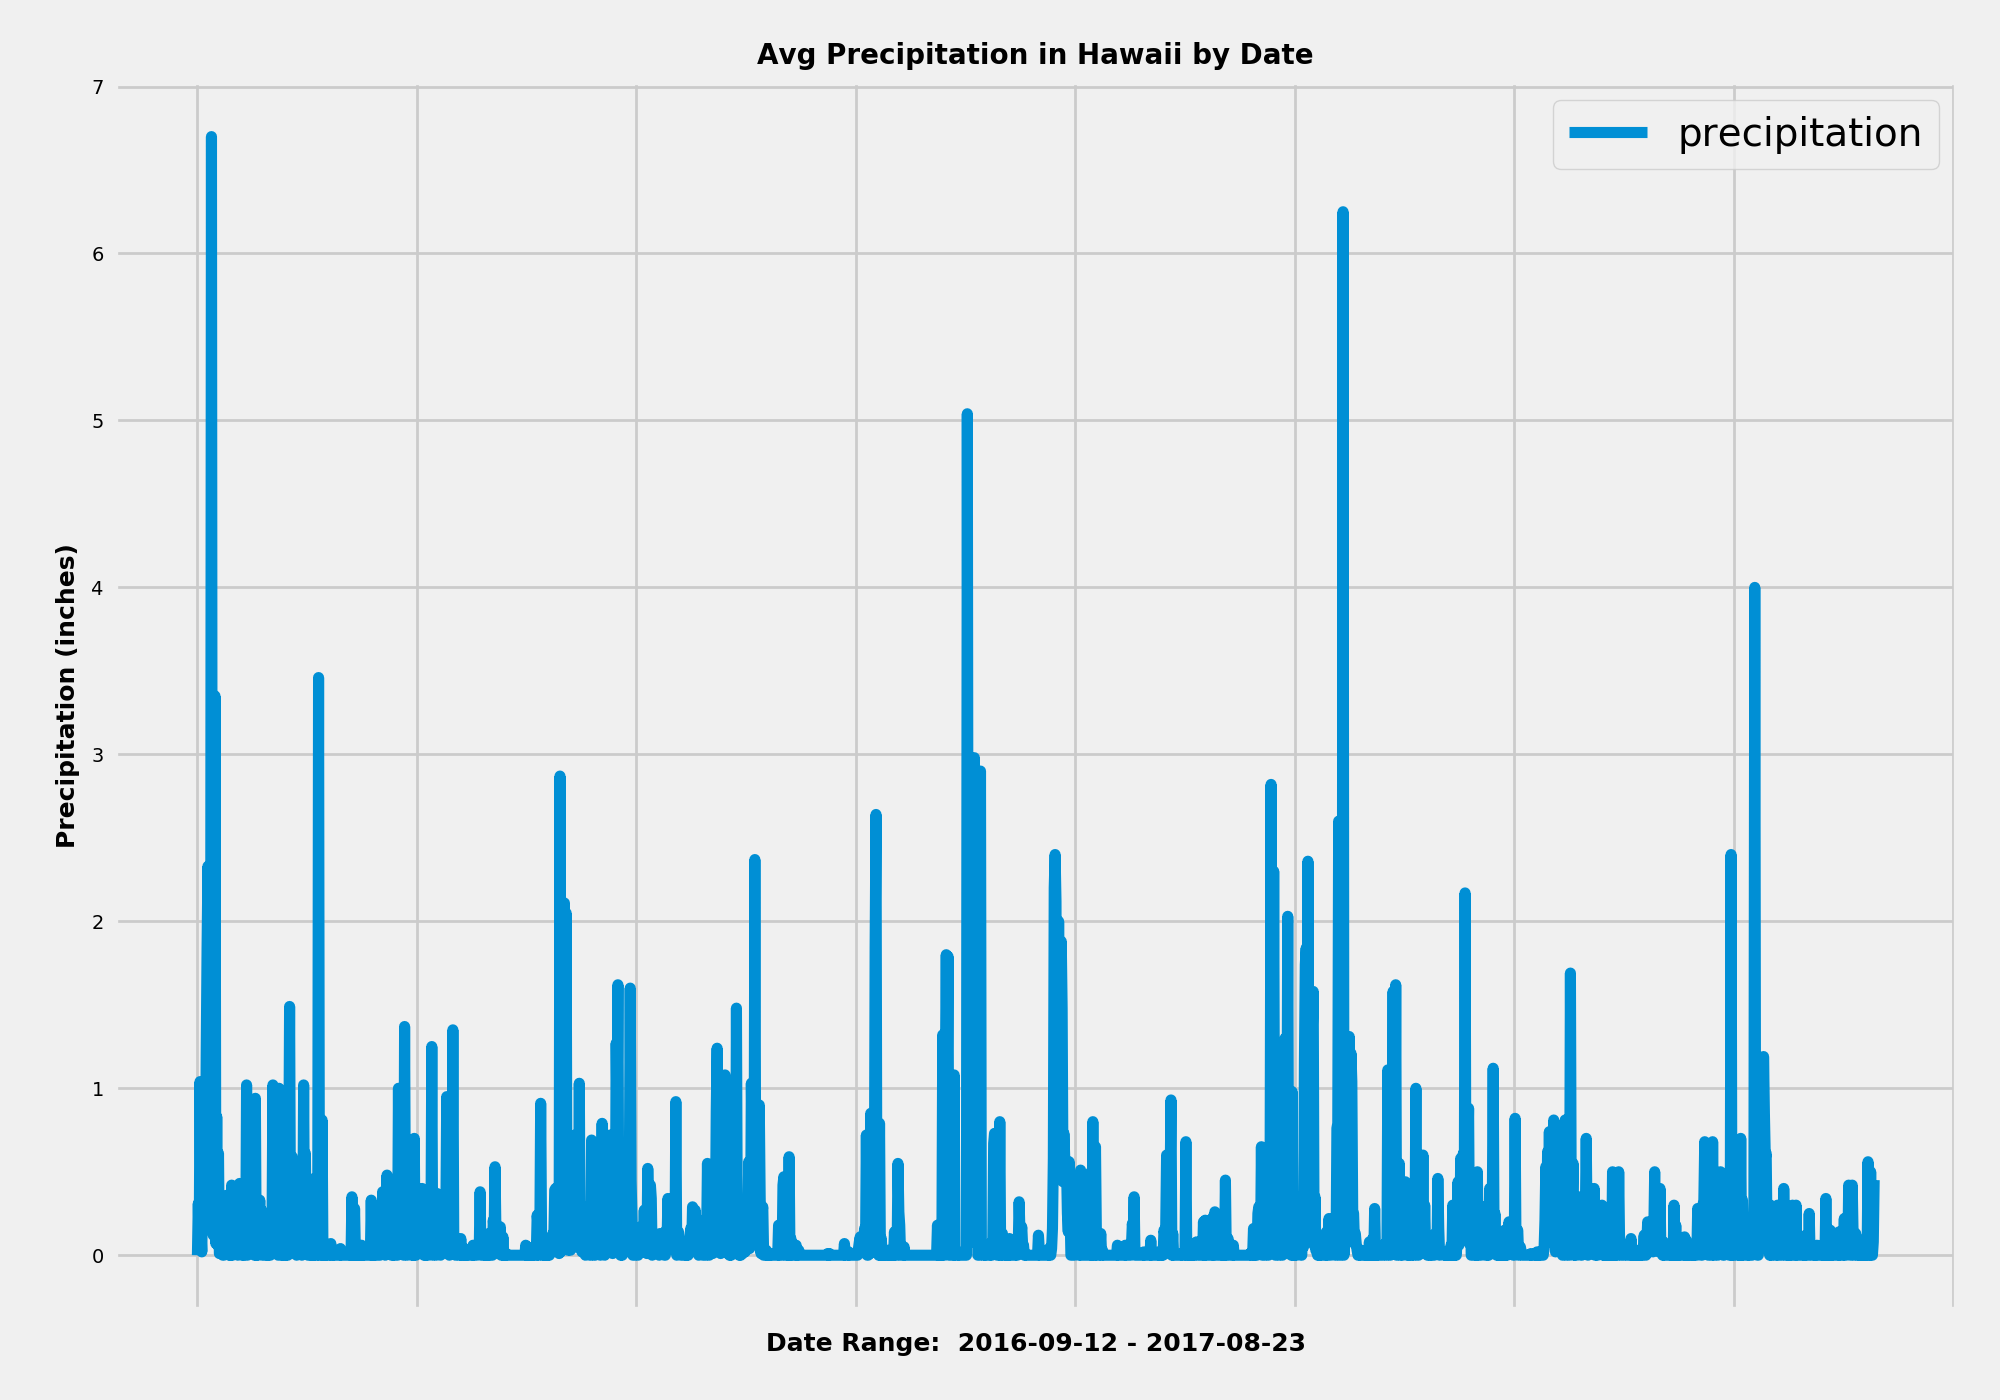

In [111]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(use_index=True, y='prcp', figsize=(10,7))
plt.title("Avg Precipitation in Hawaii by Date", fontweight='bold',size=10)
plt.xlabel(f"Date Range:  {two_years_ago} - {most_recent_date}", fontweight='bold', size=9)
plt.ylabel("Precipitation (inches)", fontweight='bold', size=9)
plt.legend(['precipitation'])
plt.tight_layout()

# Rotate the xticks for the dates
plt.yticks(size=7)
plt.xticks(rotation=45, size=7)

plt.savefig('precipitation_amounts.png')
plt.show()

In [126]:
#calcualte the summary statistics for the precipitation data
### BAD WAY THAT I DID BEFORE REALIZING I COULD USE .describe()
summary_dict = {
    'count': df.count(),
    'mean': df.mean(),
    'std_dev': df.std(),
    'min': df.min(),
    'Q1': df.quantile(.25),
    'median': df.median(),
    'Q3': df.quantile(.75),
    'max': df.max()
}
summary_df = pd.DataFrame(summary_dict)

### GOOD WAY
df.describe()

,prcp
count,1911.000000
mean,0.171005
std,0.455609
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,6.700000


In [137]:
# How many stations are available in this dataset?
stations = session.query(Station.id, Station.station, Station.name)
stations.count()

9

In [141]:
# What are the most active stations?
# List the stations and the counts in descending order.
datacount_bystation = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)
station_data_ordered = datacount_bystation.order_by(func.count(Measurement.station).desc())

for station_data in station_data_ordered:
    print(station_data)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [152]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = station_data_ordered.first().station

re_uf = session.query(Station.id, Station.name, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
re = re_uf.filter(Measurement.station == Station.station).filter(Measurement.station == most_active_station)
re[0]

(7, 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)

In [158]:
mas_dict = {
    'station_name': most_active_station,
    'station_id': re[0][0],
    'location': re[0][1],
    'lowest_temp': re[0][2],
    'highest_temp': re[0][3],
    'avg_temp': re[0][4]
}

mas_dict

{'station_name': 'USC00519281',
 'station_id': 7,
 'location': 'WAIHEE 837.5, HI US',
 'lowest_temp': 54.0,
 'highest_temp': 85.0,
 'avg_temp': 71.66378066378067}

In [168]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_twelve = session.query(Measurement.tobs).filter(Measurement.date > two_years_ago).filter(Measurement.station == most_active_station)
tobs_twelve_ordered = tobs_twelve.order_by(Measurement.tobs).all()

for tob in tobs_twelve_ordered:
    print(tob.tobs)

59.0
59.0
59.0
60.0
60.0
61.0
62.0
62.0
62.0
62.0
62.0
62.0
63.0
63.0
63.0
63.0
64.0
64.0
64.0
65.0
65.0
65.0
65.0
65.0
65.0
65.0
66.0
66.0
66.0
66.0
66.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
67.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
68.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
69.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
71.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
72.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
73.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
74.0
75.0
75.0
75.0
75.0
75.0
75.0
75.0


In [173]:
#query into df
tobs_df = pd.DataFrame(tobs_twelve_ordered)
tobs_df.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


<IPython.core.display.Javascript object>


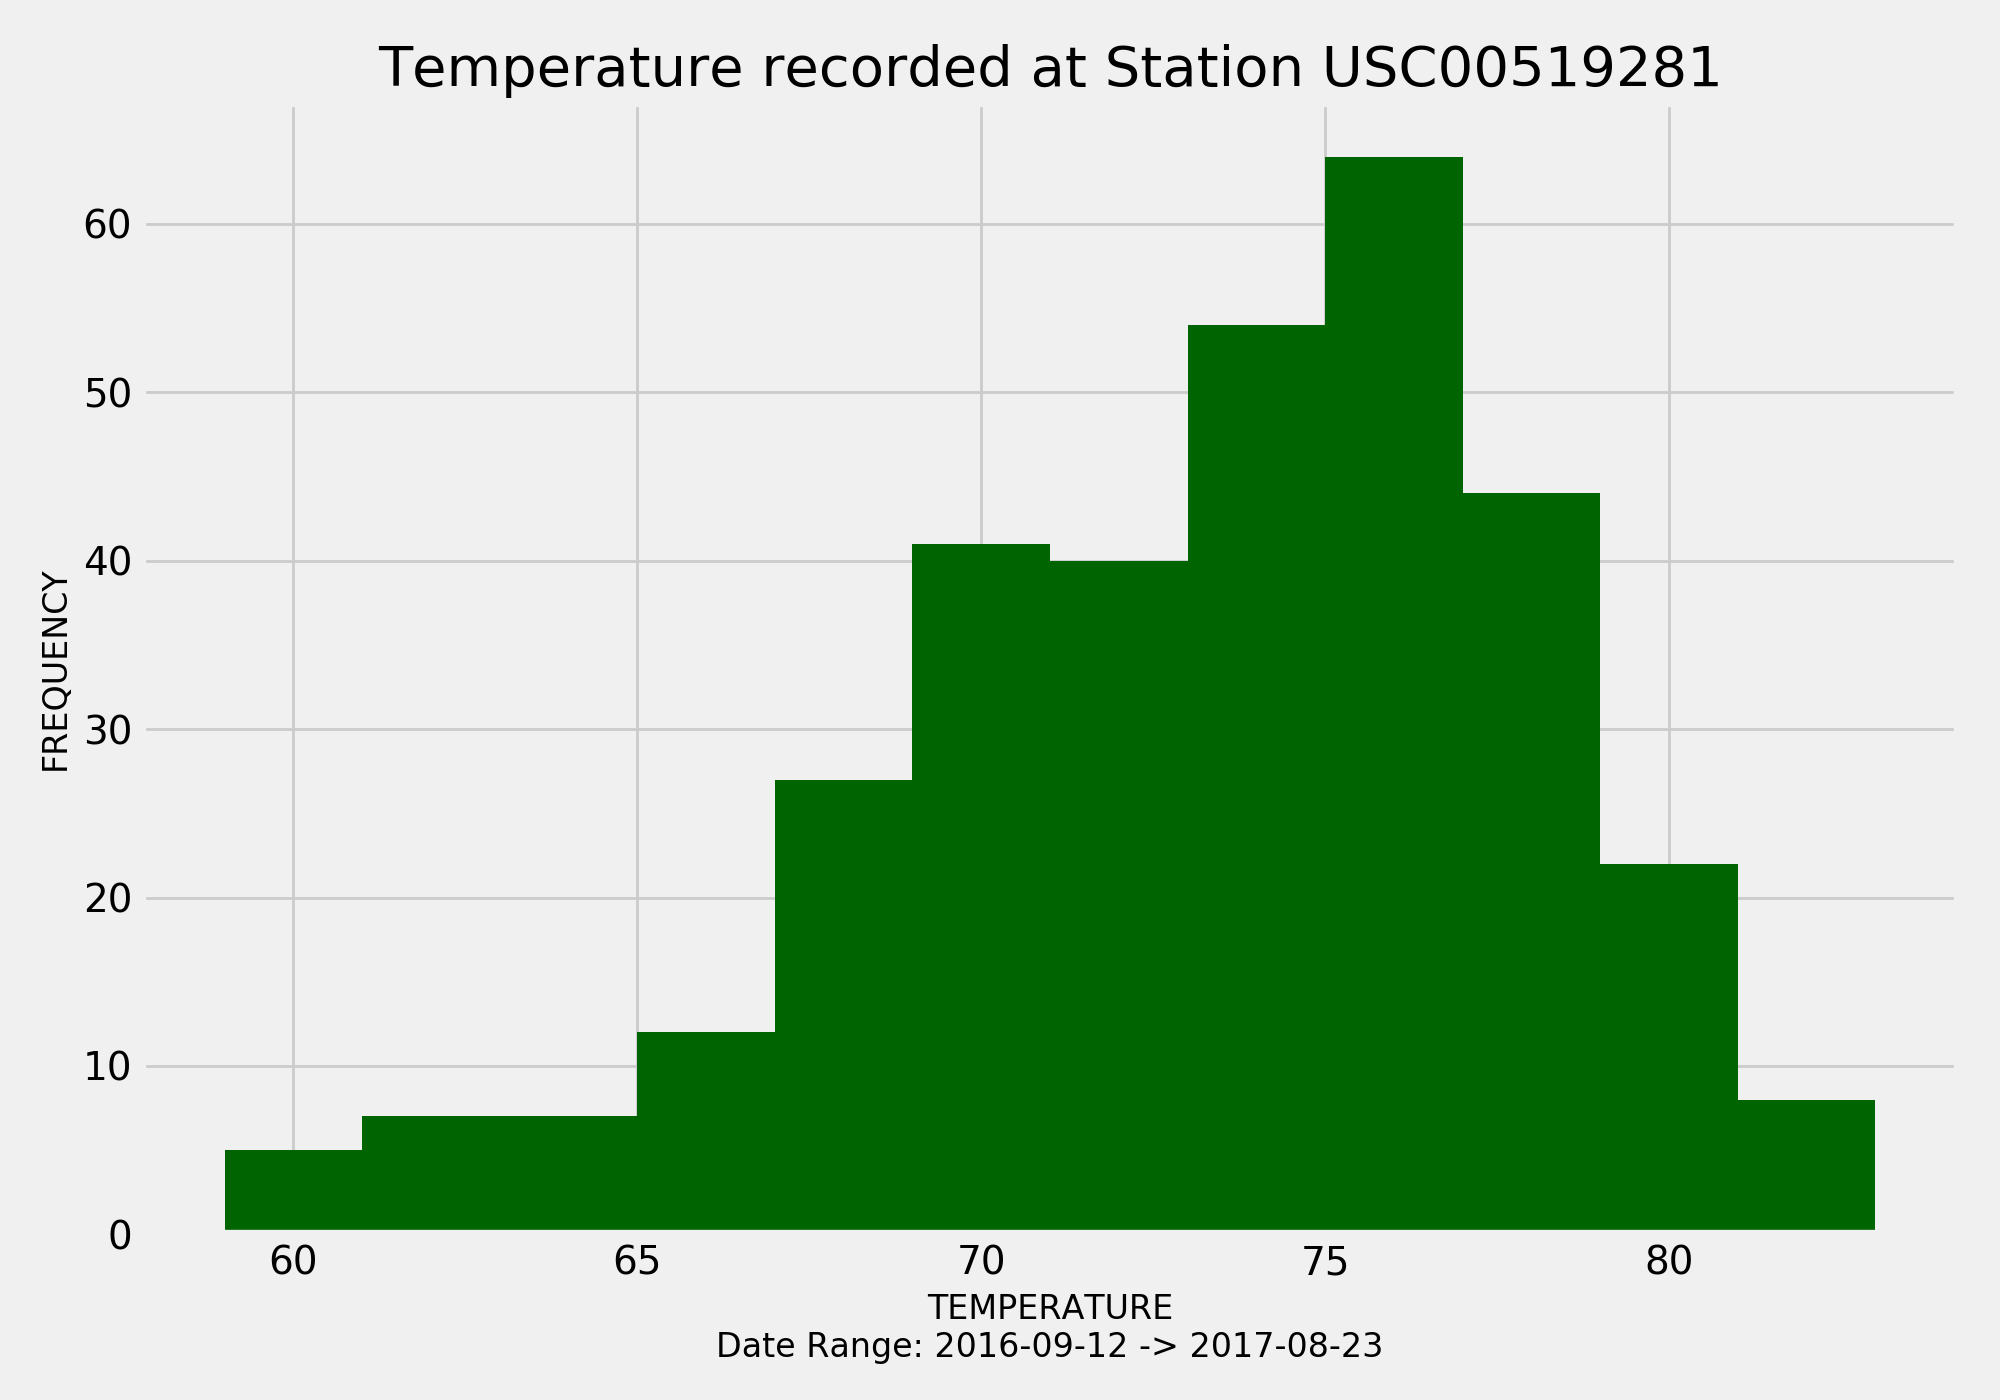

In [192]:
#plot
plt.subplots(figsize=(10,7))

plt.hist(tobs_df['tobs'], bins=12, color="darkgreen")
plt.title(f"Temperature recorded at Station {most_active_station}")
plt.xlabel(f"TEMPERATURE\nDate Range: {two_years_ago} -> {most_recent_date}", fontsize=12)
plt.ylabel("FREQUENCY", fontsize=12)
plt.tight_layout()
plt.savefig('temperature_results_hist.png')
plt.show()

In [200]:
#####OPTIONAL



# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


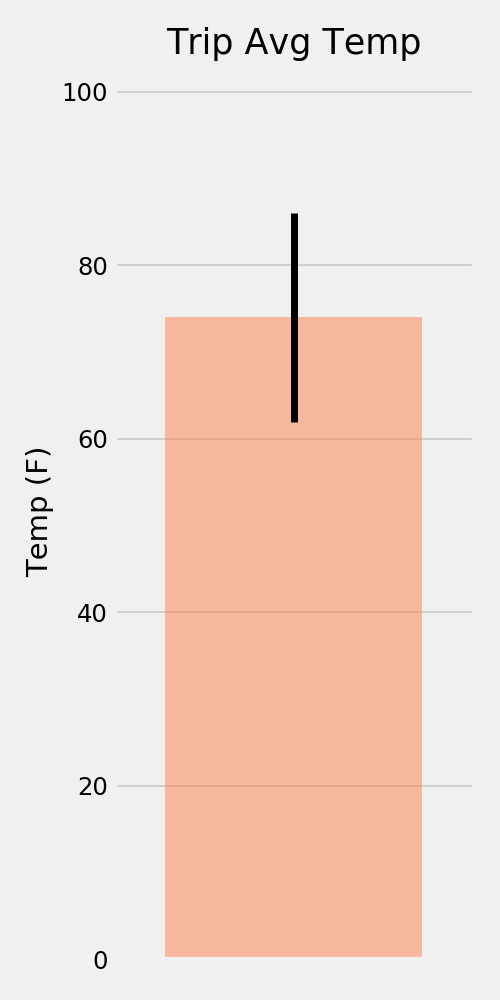

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


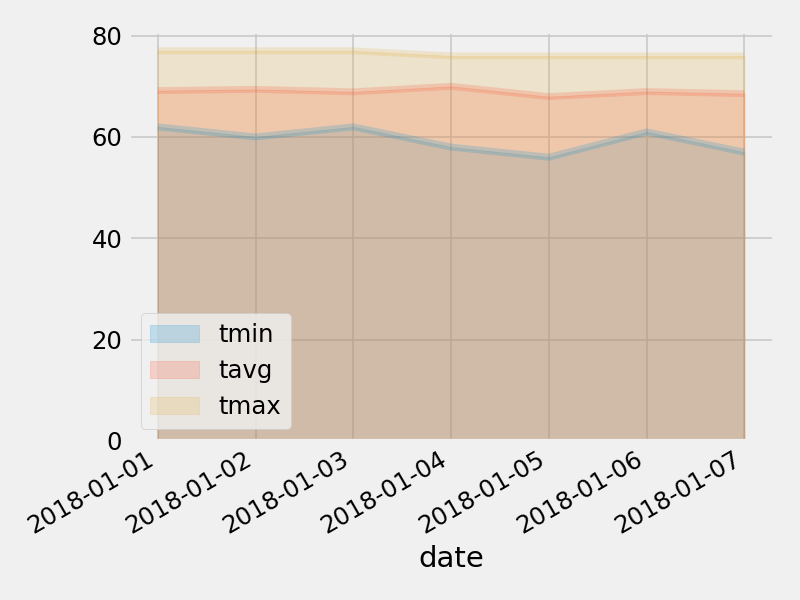

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
